In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers torch datasets scikit-learn pandas imblearn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Load dataset

In [5]:
df = pd.read_csv("/content/drive/MyDrive/FeatherFind/dataset/intents_more.csv", encoding='latin-1')

In [6]:
df = df[["intent", "examples"]]
df.dropna(inplace=True)

In [7]:
df.shape

(2053, 2)

##Shuffle dataset

In [8]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
print("Dataset Sample:")
print(df.head())

Dataset Sample:
              intent                         examples
0             affirm                             yeah
1   general_question  How do you understand language?
2  feedback_positive  Thank you that was very useful!
3              agree     Couldnât be more accurate.
4             affirm                    Yes I accept!


##Remove duplicates

In [10]:
duplicates = df[df.duplicated()]
if not duplicates.empty:
    print("Duplicate entries found:")
    print(duplicates)
else:
    print("No duplicate entries found.")

Duplicate entries found:
                    intent                                           examples
101     greet_good_evening                   Evening vibes! Let's talk birds!
337               greet_hi                                    Hello universe!
398     greet_good_evening                Evening AI got any recommendations?
410       range_prediction  Where can I find a [White-throated Kingfisher]...
454       range_prediction  Where can I find a [Blue tailed Bee eater](bir...
456               greet_hi                           Yo yo what's the latest?
621       range_prediction  Where can I find a [Red vented bulbul](bird_na...
624   greet_good_afternoon                          Afternoon bot let's chat!
672               greet_hi                               Hey what's the vibe?
762     greet_good_evening                         How's the weather tonight?
812       range_prediction  Where can I find a [White-throated Kingfisher]...
819   greet_good_afternoon             

In [11]:
print(duplicates.count())

intent      40
examples    40
dtype: int64


In [12]:
df = df.drop_duplicates()

In [13]:
duplicates = df[df.duplicated()]
if not duplicates.empty:
    print("Duplicate entries found:")
    print(duplicates)
else:
    print("No duplicate entries found.")

No duplicate entries found.


In [14]:
df.shape

(2013, 2)

<ipython-input-15-21866669fffa>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["intent"], order=df["intent"].value_counts().index, palette="viridis")


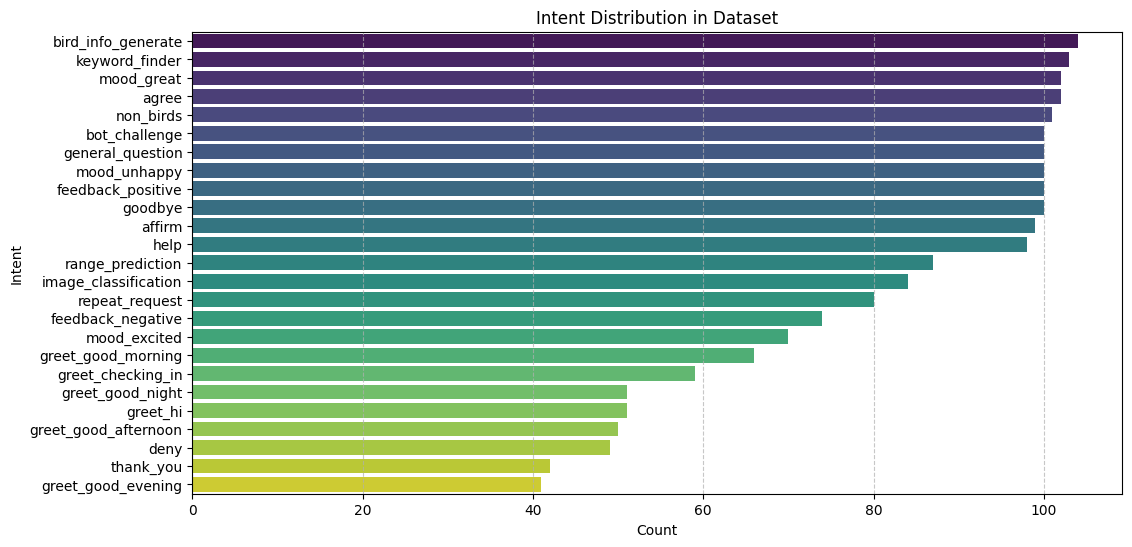

In [15]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.countplot(y=df["intent"], order=df["intent"].value_counts().index, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Intent")
plt.title("Intent Distribution in Dataset")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## Convert intents into numerical values

In [16]:
label_encoder = LabelEncoder()
df["intent"] = label_encoder.fit_transform(df["intent"])

### Label Mapping

In [17]:
# Store Label Mapping for Future Use
label_mapping = {k: int(v) for k, v in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}
print("Label Mapping:", label_mapping)

Label Mapping: {'affirm': 0, 'agree': 1, 'bird_info_generate': 2, 'bot_challenge': 3, 'deny': 4, 'feedback_negative': 5, 'feedback_positive': 6, 'general_question': 7, 'goodbye': 8, 'greet_checking_in': 9, 'greet_good_afternoon': 10, 'greet_good_evening': 11, 'greet_good_morning': 12, 'greet_good_night': 13, 'greet_hi': 14, 'help': 15, 'image_classification': 16, 'keyword_finder': 17, 'mood_excited': 18, 'mood_great': 19, 'mood_unhappy': 20, 'non_birds': 21, 'range_prediction': 22, 'repeat_request': 23, 'thank_you': 24}


## Random Oversampling

In [18]:
X = df["examples"]
y = df["intent"]

oversample = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X.values.reshape(-1, 1), y)

In [19]:
df_balanced = pd.DataFrame({"examples": X_resampled.flatten(), "intent": y_resampled})
print("Balanced Class Distribution:\n", df_balanced["intent"].value_counts())

Balanced Class Distribution:
 intent
15    104
4     104
7     104
3     104
5     104
23    104
24    104
1     104
9     104
10    104
0     104
16    104
20    104
11    104
17    104
13    104
14    104
6     104
18    104
21    104
22    104
8     104
19    104
2     104
12    104
Name: count, dtype: int64


## Dataset Preprocessing

In [20]:
stop_words = set(stopwords.words("english"))

In [21]:
import unicodedata

def clean_text(text):
    text = text.encode("latin1").decode("utf-8", errors="ignore")
    text = unicodedata.normalize("NFKD", text)
    text = re.sub(r"[^a-zA-Z0-9\s.,?!']", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()


In [22]:
df_balanced["examples"] = df_balanced["examples"].apply(clean_text)

print("Text Preprocessing Complete!")
print(df_balanced.head())

Text Preprocessing Complete!
                                      examples  intent
0   how do i know your information is correct?      15
1                                    forget it       4
2  do you follow rules or think independently?       7
3                           are you just code?       3
4                           can you try again?       5


## Split Dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["examples"], df_balanced["intent"], test_size=0.2, random_state=42
)

### Load BERT Tokenizer

In [24]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Create Dataset Objects

In [25]:
class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Convert Intent Labels to Numeric
train_labels = y_train.tolist()
test_labels = y_test.tolist()

# Create Dataset Objects
train_dataset = IntentDataset(train_encodings, train_labels)
test_dataset = IntentDataset(test_encodings, test_labels)


## Build BERT model

In [26]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_mapping)
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
training_args = TrainingArguments(
    output_dir="./bert_intent_model",
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=1
    )
    acc = accuracy_score(labels, preds)

    print(f"Train Accuracy: {acc}")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: harindu-20230712 (harindu-20230712-informatics-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.715700,2.612618,0.351923,0.283251,0.597313,0.351923
2,1.059700,0.890554,0.884615,0.884224,0.898292,0.884615
3,0.441000,0.401055,0.890385,0.887245,0.904396,0.890385
4,0.185200,0.282467,0.919231,0.919712,0.925289,0.919231
5,0.216600,0.266171,0.928846,0.929842,0.936293,0.928846
6,0.147600,0.342214,0.921154,0.921895,0.929499,0.921154
7,0.046200,0.368843,0.909615,0.911072,0.921267,0.909615
8,0.075700,0.341559,0.915385,0.916508,0.924405,0.915385


Train Accuracy: 0.35192307692307695
Train Accuracy: 0.8846153846153846
Train Accuracy: 0.8903846153846153
Train Accuracy: 0.9192307692307692
Train Accuracy: 0.9288461538461539
Train Accuracy: 0.9211538461538461
Train Accuracy: 0.9096153846153846
Train Accuracy: 0.9153846153846154


TrainOutput(global_step=1040, training_loss=0.7737885077412312, metrics={'train_runtime': 250.5197, 'train_samples_per_second': 124.541, 'train_steps_per_second': 7.784, 'total_flos': 316456381263360.0, 'train_loss': 0.7737885077412312, 'epoch': 8.0})

In [30]:
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")

Train Accuracy: 0.9288461538461539
Evaluation Results:
Accuracy: 0.9288461538461539
Precision: 0.9362934979892007
Recall: 0.9288461538461539
F1 Score: 0.9298422416834327


In [31]:
from sklearn.metrics import classification_report

y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

Train Accuracy: 0.9288461538461539
Classification Report:
                      precision    recall  f1-score   support

              affirm       0.96      1.00      0.98        23
               agree       1.00      0.89      0.94        18
  bird_info_generate       0.84      1.00      0.91        16
       bot_challenge       1.00      0.87      0.93        15
                deny       1.00      1.00      1.00        32
   feedback_negative       1.00      1.00      1.00        31
   feedback_positive       0.88      0.94      0.91        16
    general_question       0.70      0.82      0.76        17
             goodbye       0.86      0.83      0.84        23
   greet_checking_in       1.00      0.90      0.95        21
greet_good_afternoon       1.00      0.95      0.97        19
  greet_good_evening       1.00      0.71      0.83        21
  greet_good_morning       0.95      1.00      0.98        21
    greet_good_night       0.76      0.90      0.83        21
           

Train Accuracy: 0.9288461538461539


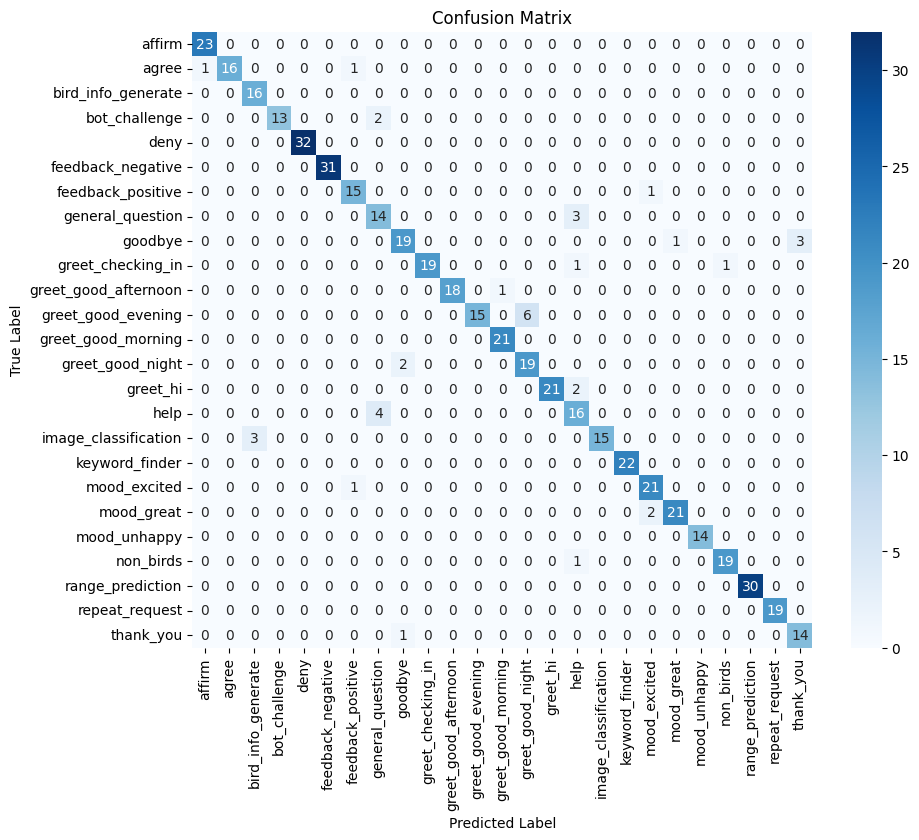

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


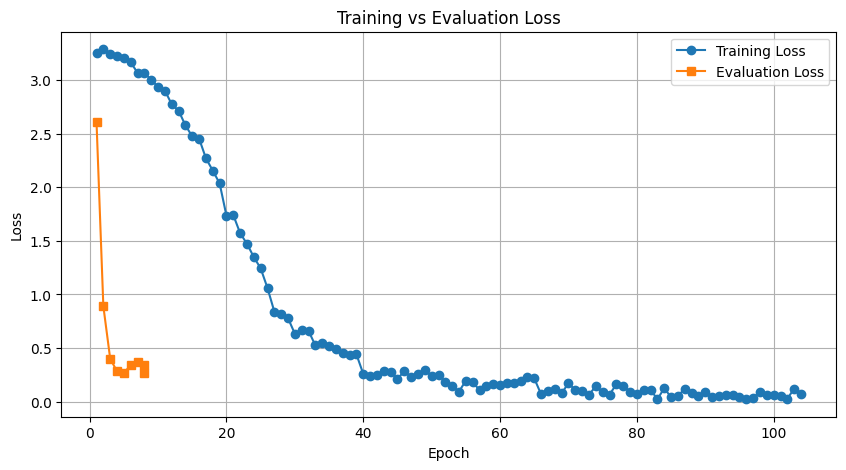

In [33]:
# Extract training and evaluation loss history
train_losses = []
eval_losses = []
epochs = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        epochs.append(log["epoch"])

# Plot Training vs. Evaluation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(epochs, eval_losses, label="Evaluation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid()
plt.show()

## Hyperparameter Tuning

In [34]:
training_args = TrainingArguments(
    output_dir="./bert_intent_model",
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=2e-5,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.073600,0.249000,0.928846,0.929978,0.935866,0.928846
2,0.050100,0.248107,0.934615,0.935628,0.940818,0.934615
3,0.084600,0.254740,0.934615,0.935621,0.940791,0.934615
4,0.045200,0.260149,0.934615,0.935756,0.941516,0.934615


Train Accuracy: 0.9288461538461539
Train Accuracy: 0.9346153846153846
Train Accuracy: 0.9346153846153846
Train Accuracy: 0.9346153846153846


TrainOutput(global_step=260, training_loss=0.07438644503171628, metrics={'train_runtime': 102.3017, 'train_samples_per_second': 304.98, 'train_steps_per_second': 9.531, 'total_flos': 158228190631680.0, 'train_loss': 0.07438644503171628, 'epoch': 4.0})

In [37]:
eval_results = trainer.evaluate()
print("Updated Evaluation Results:")
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")


Train Accuracy: 0.9346153846153846
Updated Evaluation Results:
Accuracy: 0.9346153846153846
Precision: 0.9408183949428889
Recall: 0.9346153846153846
F1 Score: 0.9356280759380436


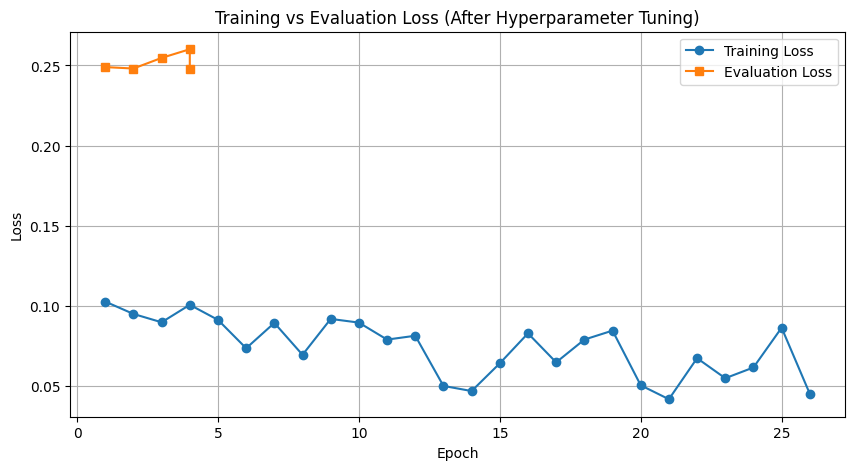

In [38]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []
epochs = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        epochs.append(log["epoch"])

# Plot Training vs. Evaluation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(epochs, eval_losses, label="Evaluation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss (After Hyperparameter Tuning)")
plt.legend()
plt.grid()
plt.show()


In [39]:
model_save_path = "/content/drive/MyDrive/FeatherFind/models"

trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Fine-tuned model saved at: {model_save_path}")


Fine-tuned model saved at: /content/drive/MyDrive/FeatherFind/models


## Test model

In [40]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "/content/drive/MyDrive/FeatherFind/models"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [41]:
label_mapping = {
    0: "affirm", 1: "agree", 2: "bird_info_generate", 3: "bot_challenge", 4: "deny", 5: "feedback_negative", 6: "feedback_positive", 7: "general_question", 8: "goodbye",
    9: "greet_checking_in", 10: "greet_good_afternoon", 11: "greet_good_evening", 12: "greet_good_morning", 13: "greet_good_night",
    14: "greet_hi", 15: "help", 16: "image_classification", 17: "keyword_finder",
    18: "mood_excited", 19: "mood_great", 20: "mood_unhappy", 21: "non_birds", 22: "range_prediction",
    23: "repeat_request", 24: "thank_you",
}


In [42]:
def predict_intent(user_input):
    inputs = tokenizer(user_input, return_tensors="pt", truncation=True, padding=True, max_length=64)

    with torch.no_grad():
        outputs = model(**inputs)

    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    predicted_intent = label_mapping[predicted_label]

    return predicted_intent


In [ ]:
while True:
    user_query = input("\nUser: ")

    if user_query.lower() in ["exit", "quit"]:
        print("Goodbye!")
        break

    predicted_intent = predict_intent(user_query)
    print(f"Predicted Intent: {predicted_intent}")
